In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import meshio
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from nets import EncodeProcessDecode
from utils import info, msh_to_trimesh, visualize


# Train

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
graphs = torch.load("data/cantilever_10.pt", weights_only=False)
train_x = torch.cat([g.x for g in graphs], dim=0)
train_y = torch.cat([g.y for g in graphs], dim=0)
train_e = torch.cat([g.edge_attr for g in graphs], dim=0)
print("Training data shape:", train_x.shape, train_y.shape)

stats = {
    "x_mean": train_x.mean(dim=0),
    "x_std": train_x.std(dim=0),
    "y_mean": train_y.mean(dim=0),
    "y_std": train_y.std(dim=0),
    "e_mean": train_e.mean(dim=0),
    "e_std": train_e.std(dim=0),
}

print("x means:", stats["x_mean"])
print("x stds:", stats["x_std"])
print("y means:", stats["y_mean"])
print("y stds:", stats["y_std"])
print("Edge_attr means:", stats["e_mean"])
print("Edge_attr stds:", stats["e_std"])


def normalize_graph(graph, stats):
    # Clone to avoid overwriting original data in memory if needed
    g = graph.clone()

    # Handle std = 0 case by replacing with 1 (skips normalization for constant features)
    x_std_safe = torch.where(
        stats["x_std"][:-1] > 0,
        stats["x_std"][:-1],
        torch.ones_like(stats["x_std"][:-1]),
    )
    y_std_safe = torch.where(
        stats["y_std"] > 0, stats["y_std"], torch.ones_like(stats["y_std"])
    )
    e_std_safe = torch.where(
        stats["e_std"] > 0, stats["e_std"], torch.ones_like(stats["e_std"])
    )

    g.x[:, :-1] = (g.x[:, :-1] - stats["x_mean"][:-1]) / x_std_safe
    g.y = (g.y - stats["y_mean"]) / y_std_safe
    g.edge_attr = (g.edge_attr - stats["e_mean"]) / e_std_safe
    return g


loader = DataLoader(
    [normalize_graph(g, stats) for g in graphs], batch_size=1, shuffle=False
)

Using device: cuda
Training data shape: torch.Size([49230, 10]) torch.Size([49230, 1])
x means: tensor([-4.9858e+00,  4.9901e+00,  2.5003e+01, -7.1764e-03, -8.7725e-03,
        -4.7783e-03, -9.7019e-02, -1.4222e+00,  1.2916e+00,  2.9454e-02])
x stds: tensor([ 3.4464,  3.4427, 14.9037,  0.2990,  0.3666,  0.3865,  5.9898,  5.5457,
        21.7109,  0.1691])
y means: tensor([0.2360])
y stds: tensor([0.3796])
Edge_attr means: tensor([-4.2070e-10,  1.3410e-09,  5.7846e-10,  1.3253e+00])
Edge_attr stds: tensor([0.7945, 0.7990, 0.7720, 0.3306])


In [17]:
latent_dim = 128
node_dim, edge_dim, output_dim = info(graphs[0], debug=True)


Node feature dim: 10
Edge feature dim: 4
Output dim: 1
Keys: ['edge_index', 'x', 'y', 'edge_attr']
Number of nodes: 4923
Number of edges: 58032


In [ ]:
import numpy as np

# Debugging: compare two graphs
g0 = graphs[0]
g1 = graphs[1]
x0 = g0.x
x1 = g1.x
dx = (x0 - x1).abs().max().item()
print("max |x0-x1| =", dx)

f0 = x0[:, -3:]
f1 = x1[:, -3:]
print("nonzero force nodes g0:", (f0.abs().sum(dim=1) > 0).sum().item())
print("nonzero force nodes g1:", (f1.abs().sum(dim=1) > 0).sum().item())

e0 = g0.edge_index
e1 = g1.edge_index
print("contact edges g0:", e0.size(1), "g1:", e1.size(1))
print("contact edge_index identical:", torch.equal(e0, e1))

idx0 = np.where(np.linalg.norm(x0[:, 3:6], axis=1) != 0)
idx1 = np.where(np.linalg.norm(x1[:, 3:6], axis=1) != 0)

print(idx0, idx1)
print(x0[idx0])
print(x1[idx1])

In [18]:
model = EncodeProcessDecode(
    node_dim=node_dim,
    edge_dim=edge_dim,
    output_dim=output_dim,
    latent_dim=latent_dim,
    message_passing_steps=15,
    use_layer_norm=True,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# for name, param in model.named_parameters():
#     print(f"{name}: {param.dtype}, shape: {param.shape}")


loss_history = []
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_nodes = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        y_pred = model(batch)
        y_true = batch.y

        loss = F.mse_loss(y_pred, y_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        total_nodes += batch.num_nodes
    avg_loss = total_loss / total_nodes
    loss_history.append(avg_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}")

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "stats": stats,
    },
    "models/model.pth",
)

Epoch 50/500, Loss: 0.308296
Epoch 100/500, Loss: 0.139284
Epoch 150/500, Loss: 0.136223
Epoch 200/500, Loss: 0.106395
Epoch 250/500, Loss: 0.093174
Epoch 300/500, Loss: 0.085127
Epoch 350/500, Loss: 0.077036
Epoch 400/500, Loss: 0.060769
Epoch 450/500, Loss: 0.048119
Epoch 500/500, Loss: 0.045199


# Traning Loss

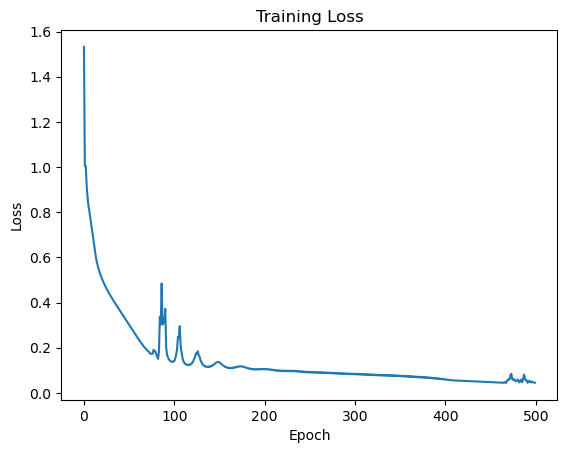

In [19]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Visualize Results

In [22]:
import pyvista


pyvista.OFF_SCREEN = True

mesh = msh_to_trimesh(meshio.read("meshes/cantilever.msh"))
g = graphs[2]
visualize(mesh, g, jupyter_backend="html", force_arrows=True)


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [23]:
model.eval()

g_pred = g.clone()
g_pred.y = model(normalize_graph(g, stats).to(device)).detach()
g_pred.y = g_pred.y * stats["y_std"].to(device) + stats["y_mean"].to(device)
visualize(mesh, g_pred, jupyter_backend="html", force_arrows=True)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [ ]:
import numpy as np

forces = np.array([[0, 2, 1], [1, 2, 3]])
weights = np.array([[1 / 4, 1 / 4, 1 / 2], [1 / 3, 1 / 3, 1 / 3]])

forces[:, None, :] * weights[:, :, None]

## Example Graph

In [ ]:
num_nodes = 4
edge_index = torch.tensor(
    [[0, 1], [1, 0], [0, 2], [2, 0], [0, 3], [3, 0], [2, 3], [3, 2]]
).T
edge_attr = torch.tensor(
    [
        [3.0, 1.0],
        [-3.0, -1.0],
        [1.0, 2.0],
        [-1.0, -2.0],
        [2.0, 2.0],
        [-2.0, -2.0],
        [0.0, 3.0],
        [0.0, -3.0],
    ]
)

D = edge_attr.size(1)
idx = edge_index[1].unsqueeze(-1).expand(-1, D)
agg = torch.zeros((num_nodes, D))
deg = torch.zeros((num_nodes, 1))
deg.scatter_add_(
    0,
    edge_index[1].unsqueeze(-1),
    torch.ones((edge_index.size(1), 1)),
).clamp_(min=1.0)
agg.scatter_add_(0, idx, edge_attr)
print(agg)
print(deg)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
graphs = torch.load("data/cantilever_1.pt", weights_only=False)
train_x = torch.cat([g["node"].x for g in graphs], dim=0)
train_y = torch.cat([g["node"].y for g in graphs], dim=0)
train_me = torch.cat([g["node", "mesh", "node"].edge_attr for g in graphs], dim=0)
train_ce = torch.cat([g["node", "contact", "node"].edge_attr for g in graphs], dim=0)
print("Training data shape:", train_x.shape, train_y.shape)

stats = {
    "x_mean": train_x.mean(dim=0),
    "x_std": train_x.std(dim=0),
    "y_mean": train_y.mean(dim=0),
    "y_std": train_y.std(dim=0),
    "me_mean": train_me.mean(dim=0),
    "me_std": train_me.std(dim=0),
    "ce_mean": train_ce.mean(dim=0),
    "ce_std": train_ce.std(dim=0),
}

print("x means:", stats["x_mean"])
print("x stds:", stats["x_std"])
print("y means:", stats["y_mean"])
print("y stds:", stats["y_std"])
print("Mesh edge_attr means:", stats["me_mean"])
print("Mesh edge_attr stds:", stats["me_std"])
print("Contact edge_attr means:", stats["ce_mean"])
print("Contact edge_attr stds:", stats["ce_std"])


def normalize_graph(graph, stats):
    # Clone to avoid overwriting original data in memory if needed
    g = graph.clone()

    # Handle std = 0 case by replacing with 1 (skips normalization for constant features)
    x_std_safe = torch.where(
        stats["x_std"][3:] > 0, stats["x_std"][3:], torch.ones_like(stats["x_std"][3:])
    )
    y_std_safe = torch.where(
        stats["y_std"] > 0, stats["y_std"], torch.ones_like(stats["y_std"])
    )
    me_std_safe = torch.where(
        stats["me_std"] > 0, stats["me_std"], torch.ones_like(stats["me_std"])
    )
    ce_std_safe = torch.where(
        stats["ce_std"] > 0, stats["ce_std"], torch.ones_like(stats["ce_std"])
    )

    g["node"].x[:, 3:] = (g["node"].x[:, 3:] - stats["x_mean"][3:]) / x_std_safe
    g["node"].y = (g["node"].y - stats["y_mean"]) / y_std_safe
    g["node", "mesh", "node"].edge_attr = (
        g["node", "mesh", "node"].edge_attr - stats["me_mean"]
    ) / me_std_safe
    g["node", "contact", "node"].edge_attr = (
        g["node", "contact", "node"].edge_attr - stats["ce_mean"]
    ) / ce_std_safe
    return g


loader = DataLoader(
    [normalize_graph(g, stats) for g in graphs], batch_size=1, shuffle=False
)